# **Vocabulary Score of Essays**
This jupyter notebook takes in a pool of essays and goes through 2 approaches of 
creating a Neural Network to get the vocabulary score for every essay.

In [33]:
# Import statements 

import re
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pylab as plt

In [12]:
#read in csv file
full_train_data = pd.read_csv('./data/train.csv', index_col=0)

## **Approach #1**

In [13]:
#parse over every row, store essay in the essays_train/test lists, and store the 6 scores in the scores_train/test list
essays_train = []
scores_train = []
essays_test = []
scores_test = []

#Splitting data into training and testing subsets

for ind, data in enumerate(full_train_data.iterrows()):
    text, cohes, syntax, vocab, phrase, gram, convs = data[1]
    if ind % 5 == 0:
      essays_test.append(text) 
      scores_test.append(vocab)
    else:
      essays_train.append(text)
      scores_train.append(vocab)

In [14]:
#make into np arrays
np_essays_train = np.array(essays_train)
np_essays_test = np.array(essays_test)
np_scores_train = np.array(scores_train)
np_scores_test = np.array(scores_test)

In [15]:
#Implement TF-IDF over all essays
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(np_essays_train)
idf_vector_for_every_word = tfIdfVectorizer.idf_

In [16]:
#create word to index and index to word mapping to make looking up values easy
indices=np.array(tfIdfVectorizer.get_feature_names())
ind_to_word = {} 
word_to_ind = {}
for index, word in enumerate(indices):
  ind_to_word[index] = word
  word_to_ind[word] = index

In [17]:
#Building the array of TF-IDF vectors for the training data
tfidfs_train = []

for index, essay in enumerate(np_essays_train):
  tfidfs_train.append(tfIdf[index].toarray()[0])

np_tfidfs_train = np.array(tfidfs_train)

In [18]:
model = Sequential([
    Dense(2000, activation='relu'),
    Dropout(0.5),
    Dense(1000, activation='relu'),
    Dropout(0.5),
    Dense(500, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(1, activation='relu')
])

model.compile(optimizer='adam',
                loss='mse',
                metrics=['mean_absolute_error'])

In [13]:
model.fit(np_tfidfs_train, np_scores_train, batch_size=16, epochs=20)

Epoch 1/20
196/196 [==============================] - 16s 79ms/step - loss: 0.7307 - mean_absolute_error: 0.6365
Epoch 2/20
196/196 [==============================] - 16s 80ms/step - loss: 0.3630 - mean_absolute_error: 0.4759
Epoch 3/20
196/196 [==============================] - 20s 100ms/step - loss: 0.2953 - mean_absolute_error: 0.4312
Epoch 4/20
196/196 [==============================] - 25s 128ms/step - loss: 0.2538 - mean_absolute_error: 0.3975
Epoch 5/20
196/196 [==============================] - 26s 135ms/step - loss: 0.1925 - mean_absolute_error: 0.3441
Epoch 6/20
196/196 [==============================] - 26s 134ms/step - loss: 0.1550 - mean_absolute_error: 0.3096
Epoch 7/20
196/196 [==============================] - 19s 98ms/step - loss: 0.1349 - mean_absolute_error: 0.2874
Epoch 8/20
196/196 [==============================] - 28s 141ms/step - loss: 0.1121 - mean_absolute_error: 0.2605
Epoch 9/20
196/196 [==============================] - 27s 139ms/step - loss: 0.0973 - mean_

In [19]:
#Building the array of TF-IDF vectors for the testing data
tf_len = len(idf_vector_for_every_word)
tfidfs_test = []
unknown_words = []

for index, essay in enumerate(np_essays_test):
  essay_wo_punc = re.sub(r'[^\w\s]', '', essay)
  essay_lower = essay_wo_punc.lower()
  split_essay = re.split('[^a-zA-Z]+', essay_lower)
  tf = [0 for _ in range(tf_len)]
  for word in split_essay:
    if word in word_to_ind:
      tf[word_to_ind[word]] += 1
    else:
      unknown_words.append(word)
  tfIdf = np.array(tf) * idf_vector_for_every_word
  np_tfidf_not_normal = np.array(tfIdf)
  tfIdf_norm = np_tfidf_not_normal/np.linalg.norm(np_tfidf_not_normal)
  tfidfs_test.append(tfIdf_norm)

np_tfidfs_test = np.array(tfidfs_test)

In [15]:
#Evaluate success of model
model.evaluate(np_tfidfs_test, np_scores_test)

25/25 [==============================] - 1s 25ms/step - loss: 0.2839 - mean_absolute_error: 0.4110


[0.2838650345802307, 0.4110131561756134]

## **Approach #2**

In [20]:
#Reads in 333,000 most common words in English language, not currently used later in code but might be useful...
all_vocab_words = pd.read_csv('./data/unigram_freq.csv', index_col=0)
all_vocabs = np.array([data[0] for data in all_vocab_words.iterrows()])

In [59]:
#parse over every row, store essay in the essays_train/test lists, and store the 6 scores in the scores_train/test list
essays_train = []
scores_train = []
essays_test = []
scores_test = []
all_essays = []
all_vocabs_words = []

#Technique for splitting essays into training and testing data and results

for ind, data in enumerate(full_train_data.iterrows()):
    text, cohes, syntax, vocab, phrase, gram, convs = data[1]
    essays_train.append(text) if ind % 5 != 0 else essays_test.append(text)
    #scores_train.append([cohes, syntax, vocab, phrase, gram, convs]) if ind % 5 != 0 else scores_test.append(
    #    [cohes, syntax, vocab, phrase, gram, convs]) 
    scores_train.append(vocab) if ind % 5 != 0 else scores_test.append(vocab) 


In [60]:
#make into np arrays
np_essays_train = np.array(essays_train)
np_essays_test = np.array(essays_test)
np_scores_train = np.array(scores_train)
np_scores_test = np.array(scores_test)

In [61]:
# building dictionary with vocab word as key and count as value
vocab_dict = {}

for data in all_vocab_words[:50001].iterrows():
  vocab_dict[data[0]] = data[1][0]

In [62]:
#get frequency of most common word, 'the' to use to do frequency
normalizer_frequency = vocab_dict["the"]

In [63]:
#create vocab to index and index to vocab mappings
vocab_word_to_index = {}
index_to_vocab_word = {}
for index, word in enumerate(vocab_dict):
  vocab_word_to_index[word] = index
  index_to_vocab_word[index] = word

In [64]:
#Create idf score for every value
our_idf = []
#create idf for every word:
for word, amount in vocab_dict.items():
  idf_score = math.log((normalizer_frequency + 1)/(amount + 1))
  our_idf.append(idf_score)

np_idf = np.array(our_idf)

In [65]:
#Parse through every training essay and remove punction and make every word lower case. 
#Take every word not in most common 50,000 words and add to list of unknown words. 
#Create TF list for every essay
unknown_words = []
train_tf_essays = []
essay_length = []
total_word_count = 0
for essay in np_essays_train:
  essay_wo_punc = re.sub(r'[^\w\s]', '', essay)
  essay_lower = essay_wo_punc.lower()
  split_essay = re.split('[^a-zA-Z]+', essay_lower)
  essay_count = len(split_essay)
  tf = [0 for _ in range(50000)]
  #calculate TF Score
  for word in split_essay:
    if word in vocab_dict:
      tf[vocab_word_to_index[word]] += 1
    else:
      unknown_words.append(word)
  train_tf_essays.append(tf)
  total_word_count += essay_count
  essay_length.append(essay_count)
np_train_tf_essays = np.array(train_tf_essays)
np_train_essay_lengths = np.array(essay_length)

In [66]:
#Parse through every testing essay and remove punction and make every word lower case. 
#Take every word not in most common 50,000 words and add to list of unknown words. 
#Create TF list for every essay
test_tf_essays = []
for essay in np_essays_test:
  essay_wo_punc = re.sub(r'[^\w\s]', '', essay)
  essay_lower = essay_wo_punc.lower()
  split_essay = re.split('[^a-zA-Z]+', essay_lower)
  total_word_count += len(split_essay)
  tf = [0 for _ in range(50000)]
  #calculate TF Score
  for word in split_essay:
    if word in vocab_dict:
      tf[vocab_word_to_index[word]] += 1
    else:
      unknown_words.append(word)
  test_tf_essays.append(tf)
np_test_tf_essays = np.array(test_tf_essays)

In [67]:
#interesting data stat
print("Ratio of mispelled/unknown words:", len(unknown_words)/total_word_count)

Ratio of mispelled/unknown words: 0.016477343355504156


In [68]:
#confirm that datasets are the right size (.8 vs. .2)
print(len(train_tf_essays))
print(len(test_tf_essays))

3128
783


In [69]:
#confirm that tf and idf vectors are equal size
print(len(np_train_tf_essays[0]))
print(len(np_idf))

50000
50000


In [70]:
#Create modified TF-IDF scores for every training essay
tf_idf_per_essay = np_train_tf_essays*np_idf


In [71]:
#create data-points to graph
sum_tf_idf_every_essay = np.array([sum(arr) for arr in tf_idf_per_essay])
avg_tf_idf_score_train = sum_tf_idf_every_essay/essay_length

In [87]:
#calculate average unnormalized tf-idf score for every vocabulary score
num_perc_per_score = {}
sum_perc_per_score = {}

for index, score in enumerate(np_scores_train):
  if score in sum_perc_per_score:
    sum_perc_per_score[score] += avg_tf_idf_score_train[index]
    num_perc_per_score[score] += 1
  else:
    sum_perc_per_score[score] = avg_tf_idf_score_train[index]
    num_perc_per_score[score] = 1

avg_per_score = {}
for key, value in sum_perc_per_score.items():
  avg_per_score[key] = sum_perc_per_score[key]/num_perc_per_score[key]

print(avg_per_score)
print(avg_per_score.keys())
print(avg_per_score.values())

{3.0: 3.6026995897246827, 4.5: 3.819877557523774, 3.5: 3.694005800577508, 2.5: 3.5245244844444925, 4.0: 3.736751379875509, 5.0: 3.907038553830536, 2.0: 3.466454276277619, 1.5: 3.4566253527833934, 1.0: 4.1584454341836254}
dict_keys([3.0, 4.5, 3.5, 2.5, 4.0, 5.0, 2.0, 1.5, 1.0])
dict_values([3.6026995897246827, 3.819877557523774, 3.694005800577508, 3.5245244844444925, 3.736751379875509, 3.907038553830536, 3.466454276277619, 3.4566253527833934, 4.1584454341836254])


Text(0.5, 1.0, 'TF-IDF Average Score vs. Vocabulary Score')

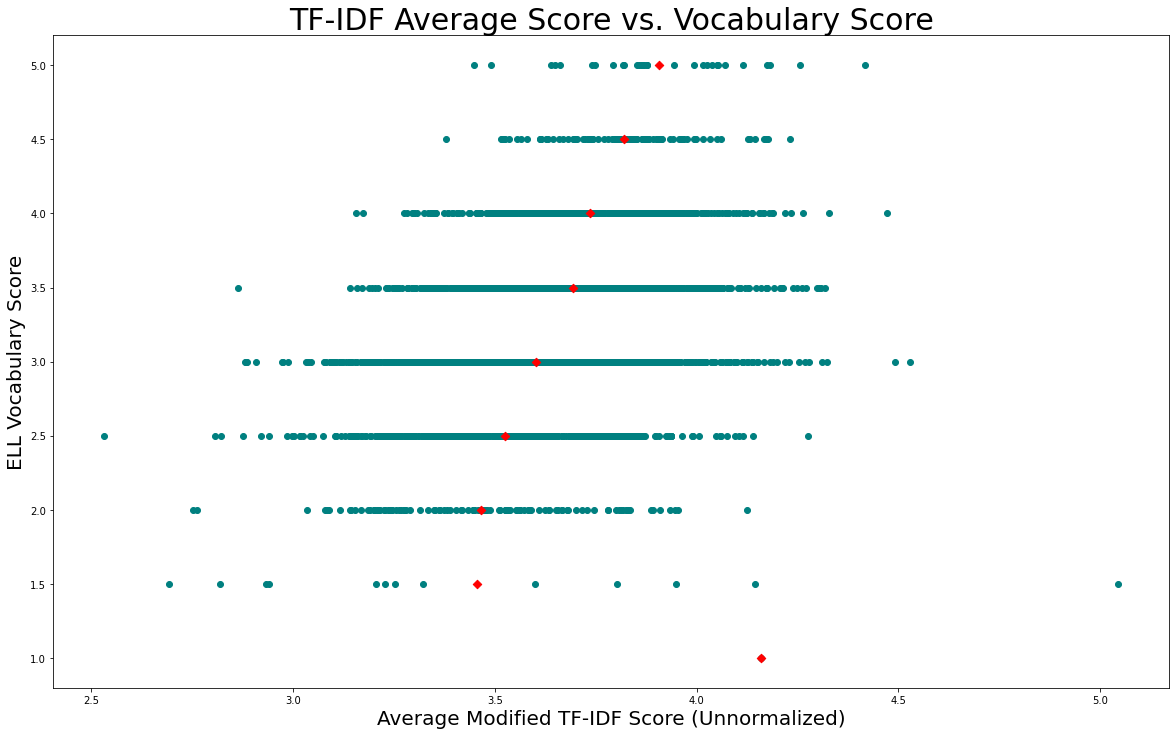

In [99]:
#make plot shown below
fig,ax = plt.subplots(figsize=(20, 12))
fig.patch.set_facecolor('white')
ax.scatter(avg_tf_idf_score_train,np_scores_train, color=['teal'])
ax.scatter(avg_per_score.values(), avg_per_score.keys(), color=['red'], marker='D')
ax.set_xlabel('Average Modified TF-IDF Score (Unnormalized)', fontdict={'fontsize':20})
ax.set_ylabel('ELL Vocabulary Score', fontdict={'fontsize':20})
ax.set_title("TF-IDF Average Score vs. Vocabulary Score",  fontdict={'fontsize':30})

In [74]:
#take norm of vector
tf_idf_norm_train = tf_idf_per_essay/np.linalg.norm(tf_idf_per_essay)

In [75]:
#Create modified TF-IDF scores for every testing essay
tf_idf_per_essay_test = np_test_tf_essays*np_idf
tf_idf_norm_test = tf_idf_per_essay_test/np.linalg.norm(tf_idf_per_essay_test)

In [82]:
#Build Neural Network
model_app_3 = Sequential([
    Dense(2000, activation='relu'),
    Dropout(0.5),
    Dense(1000, activation='relu'),
    Dropout(0.5),
    Dense(500, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(1, activation='relu')
])

model_app_3.compile(optimizer='adam',
                loss='mse',
                metrics=['mean_absolute_error'])

In [83]:
#Train model with normalized tf-idf training data, and associated vocab scores
model_app_3.fit(tf_idf_norm_train, np_scores_train, batch_size=16, epochs=20)

Epoch 1/20
196/196 [==============================] - 35s 173ms/step - loss: 0.8237 - mean_absolute_error: 0.6472
Epoch 2/20
196/196 [==============================] - 35s 177ms/step - loss: 0.3588 - mean_absolute_error: 0.4738
Epoch 3/20
196/196 [==============================] - 37s 186ms/step - loss: 0.3647 - mean_absolute_error: 0.4766
Epoch 4/20
196/196 [==============================] - 41s 209ms/step - loss: 0.2903 - mean_absolute_error: 0.4261
Epoch 5/20
196/196 [==============================] - 47s 237ms/step - loss: 0.2800 - mean_absolute_error: 0.4186
Epoch 6/20
196/196 [==============================] - 46s 237ms/step - loss: 0.2556 - mean_absolute_error: 0.3971
Epoch 7/20
196/196 [==============================] - 49s 249ms/step - loss: 0.2395 - mean_absolute_error: 0.3834
Epoch 8/20
196/196 [==============================] - 45s 230ms/step - loss: 0.2079 - mean_absolute_error: 0.3599
Epoch 9/20
196/196 [==============================] - 37s 188ms/step - loss: 0.2039 - me

In [84]:
model_app_3.evaluate(tf_idf_norm_test, np_scores_test)

25/25 [==============================] - 1s 48ms/step - loss: 0.6524 - mean_absolute_error: 0.5563


[0.6523594856262207, 0.5562986731529236]

## **OLD Code Below - IGNORE, here for archiving purposes**
Most of this code was previous iterations of testing, and is not used in our solutions, but here in case we want to look back on the model training.

In [33]:
#old code
#model2.fit(tf_idf_per_essay, np_scores_train, batch_size=16, epochs=20)

Epoch 1/20
123/123 [==============================] - 66s 518ms/step - loss: 3.1639 - accuracy: 0.0032
Epoch 2/20
123/123 [==============================] - 63s 509ms/step - loss: 1.5439 - accuracy: 0.0032
Epoch 3/20
123/123 [==============================] - 61s 492ms/step - loss: 1.2034 - accuracy: 0.0032
Epoch 4/20
123/123 [==============================] - 58s 468ms/step - loss: 0.7640 - accuracy: 0.0032
Epoch 5/20
123/123 [==============================] - 60s 488ms/step - loss: 0.5917 - accuracy: 0.0032
Epoch 6/20
123/123 [==============================] - 58s 470ms/step - loss: 0.4306 - accuracy: 0.0032
Epoch 7/20
123/123 [==============================] - 57s 463ms/step - loss: 0.3928 - accuracy: 0.0032
Epoch 8/20
123/123 [==============================] - 57s 462ms/step - loss: 0.3810 - accuracy: 0.0032
Epoch 9/20
123/123 [==============================] - 57s 462ms/step - loss: 0.3565 - accuracy: 0.0032
Epoch 10/20
123/123 [==============================] - 58s 468ms/step - l

In [39]:
model2.evaluate(tf_idf_per_essay_test, np_scores_test)

62/62 [==============================] - 6s 93ms/step - loss: 0.3255 - accuracy: 0.0015


[0.32551485300064087, 0.0015345268184319139]

In [40]:
model2.save("common_words_tf-idf_model.h5")

- use LSTMS on word embeddings


In [74]:
model3 = Sequential([
    Dense(2000, activation='relu'),
    Dropout(0.5),
    Dense(1000, activation='relu'),
    Dropout(0.5),
    Dense(500, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(1, activation='relu')
])

model3.compile(optimizer='adam',
                loss='mse',
                metrics=['accuracy'])

In [65]:
tf_idf_per_essay

array([[ 24.        ,   3.54098918,  48.55919941, ...,   0.        ,
          0.        ,   0.        ],
       [ 32.        ,  14.16395673,  10.40554273, ...,   0.        ,
          0.        ,   0.        ],
       [ 24.        ,  31.86890264,   6.93702849, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 12.        ,   0.        ,  24.2795997 , ...,   0.        ,
          0.        ,   0.        ],
       [ 16.        ,  10.62296755,  13.87405697, ...,   0.        ,
          0.        ,   0.        ],
       [108.        ,  10.62296755,  97.11839881, ...,   0.        ,
          0.        ,   0.        ]])

In [75]:
model3.fit(tf_idf_per_essay, np_scores_train, batch_size=100, epochs=50)

Epoch 1/50
20/20 [==============================] - 6s 255ms/step - loss: 3.0916 - accuracy: 0.0028
Epoch 2/50
20/20 [==============================] - 5s 250ms/step - loss: 1.9745 - accuracy: 0.0032
Epoch 3/50
20/20 [==============================] - 5s 252ms/step - loss: 1.4483 - accuracy: 0.0032
Epoch 4/50
20/20 [==============================] - 5s 256ms/step - loss: 1.0356 - accuracy: 0.0032
Epoch 5/50
20/20 [==============================] - 5s 258ms/step - loss: 0.8050 - accuracy: 0.0032
Epoch 6/50
20/20 [==============================] - 5s 262ms/step - loss: 0.6391 - accuracy: 0.0032
Epoch 7/50
20/20 [==============================] - 5s 265ms/step - loss: 0.5174 - accuracy: 0.0032
Epoch 8/50
20/20 [==============================] - 5s 267ms/step - loss: 0.4410 - accuracy: 0.0032
Epoch 9/50
20/20 [==============================] - 5s 269ms/step - loss: 0.3999 - accuracy: 0.0032
Epoch 10/50
20/20 [==============================] - 5s 271ms/step - loss: 0.3472 - accuracy: 0.0032

In [67]:
model3.evaluate(tf_idf_per_essay_test, np_scores_test)

62/62 [==============================] - 3s 49ms/step - loss: 0.4011 - accuracy: 0.0015


[0.4010857343673706, 0.0015345268184319139]

In [76]:
model3.save("common_words_tf-idf_new_model.h5")

In [ ]:
tf_idf_per_essay 